In [2]:
# Requiremnts
import os
import shutil
import tempfile
import glob
import re
import matplotlib
import numpy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet, BasicUNet
from monai.utils import set_determinism
from monai.transforms import (LoadImage, LoadImaged)

os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

print_config()

/home/hua/miniconda3/envs/LGMD/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.0
Numpy version: 1.23.1
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/hua/miniconda3/envs/LGMD/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.12.2
gdown version: 4.7.1
TorchVision version: 0.13.1
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.4.4
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.2.2
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
# Setup data directory
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = os.getcwd() if directory is None else directory
print(root_dir)

# set tensorboard
#writer = SummaryWriter()

# Set deterministic training for reproducibility
set_determinism(seed=0)

# set Rawdata_dicts
fat_series = sorted(
    glob.glob(os.path.join(root_dir, "Data", "Training", "Fat","*.nii.gz")))
water_series = sorted(
    glob.glob(os.path.join(root_dir, "Data", "Training", "Water","*.nii.gz")))
mask_series = sorted(
    glob.glob(os.path.join(root_dir, "Data", "Training", "Label","*.nii.gz")))

Rawdata_dicts = [
    {"fat": fat_name, "water": water_name, "label": label_name}
    for fat_name, water_name, label_name,  in zip(fat_series, water_series, mask_series)
]

print(f"Rawdata_dicts example: \n {Rawdata_dicts[0]} \n")
print(f"Rawdata_dicts length: \n {len(Rawdata_dicts)} \n")
Rawdata_dicts

/home/hua/Muscle_seg
Rawdata_dicts example: 
 {'fat': '/home/hua/Muscle_seg/Data/Training/Fat/THIGH_001_0000.nii.gz', 'water': '/home/hua/Muscle_seg/Data/Training/Water/THIGH_001_0001.nii.gz', 'label': '/home/hua/Muscle_seg/Data/Training/Label/THIGH_001.nii.gz'} 

Rawdata_dicts length: 
 66 



[{'fat': '/home/hua/Muscle_seg/Data/Training/Fat/THIGH_001_0000.nii.gz',
  'water': '/home/hua/Muscle_seg/Data/Training/Water/THIGH_001_0001.nii.gz',
  'label': '/home/hua/Muscle_seg/Data/Training/Label/THIGH_001.nii.gz'},
 {'fat': '/home/hua/Muscle_seg/Data/Training/Fat/THIGH_002_0000.nii.gz',
  'water': '/home/hua/Muscle_seg/Data/Training/Water/THIGH_002_0001.nii.gz',
  'label': '/home/hua/Muscle_seg/Data/Training/Label/THIGH_002.nii.gz'},
 {'fat': '/home/hua/Muscle_seg/Data/Training/Fat/THIGH_003_0000.nii.gz',
  'water': '/home/hua/Muscle_seg/Data/Training/Water/THIGH_003_0001.nii.gz',
  'label': '/home/hua/Muscle_seg/Data/Training/Label/THIGH_003.nii.gz'},
 {'fat': '/home/hua/Muscle_seg/Data/Training/Fat/THIGH_004_0000.nii.gz',
  'water': '/home/hua/Muscle_seg/Data/Training/Water/THIGH_004_0001.nii.gz',
  'label': '/home/hua/Muscle_seg/Data/Training/Label/THIGH_004.nii.gz'},
 {'fat': '/home/hua/Muscle_seg/Data/Training/Fat/THIGH_005_0000.nii.gz',
  'water': '/home/hua/Muscle_seg/Da

C:\Users\Hua\AppData\Local\Temp\ipykernel_23416\2215604622.py:9: RuntimeWarning: invalid value encountered in true_divide
  Fatfraction = numpy.divide(fat, Fatfraction_denominator)


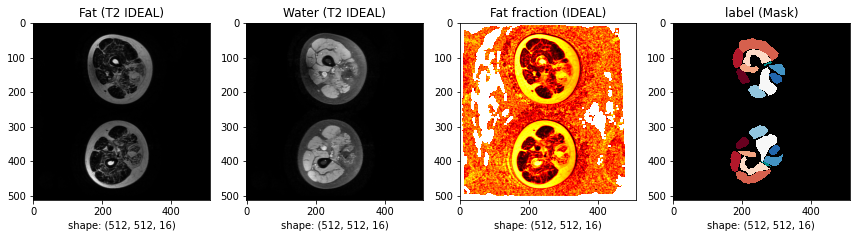

In [3]:
# load function
loadraw = LoadImaged(keys=["fat", "label", "water"])
# laod raw dict example
Rawdata_dict_eg = loadraw(Rawdata_dicts[0])

fat, water, label = Rawdata_dict_eg["fat"], Rawdata_dict_eg["water"], Rawdata_dict_eg["label"]

Fatfraction_denominator = numpy.add(fat, water)
Fatfraction = numpy.divide(fat, Fatfraction_denominator)

fig, ax = plt.subplots(1,4, figsize=(12, 48))

cmap = matplotlib.colors.ListedColormap(['#000000', '#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#92c5de', '#4393c3', '#2166ac', '#053061', '#008b8b'])

ax[0].imshow(fat[:, :, 5], cmap="gray")
ax[0].set(title='Fat (PD IDEAL)', xlabel= f"shape: {fat.shape}", ylabel='')
ax[1].imshow(water[:, :, 5], cmap="gray")
ax[1].set(title='Water (PD IDEAL)', xlabel= f"shape: {water.shape}", ylabel='')
ax[2].imshow(Fatfraction[:, :, 5], cmap="hot")
ax[2].set(title='Fat fraction (IDEAL)', xlabel= f"shape: {Fatfraction.shape}", ylabel='')
ax[3].imshow(label[:, :, 5], interpolation='nearest', cmap=cmap)
ax[3].set(title='label (Mask)', xlabel= f"shape: {label.shape}", ylabel='')

fig.tight_layout()

In [4]:
Rawdata_dict_eg.keys()
#['Sartorius muscle', 'Rectus femoris muscle', 'Vastus lateralis muscle', 'Vastus intermedius muscle', 'Vastus medialis muscle', 'Adductor magnus muscle', 'Adductor longus muscle', 'Gracilis muscle', 'Biceps femoris muscle (long head)', 'Semitendinosus muscle', 'Semimembranosus muscle', 'Adductor brevis muscle', 'Biceps femoris muscle (short head)']

dict_keys(['fat', 'water', 'label', 'fat_meta_dict', 'label_meta_dict', 'water_meta_dict'])

In [5]:
loadraw = LoadImaged(keys=["fat", "label", "water"])

def IDEAL_caculator(Rawdata_dict_one):
    '''calculate each muscle voxel sum, fatfraction sum, and average fatfraction in each instance '''
    import warnings
    warnings.simplefilter('ignore')
    Rawdata_dict_one = loadraw(Rawdata_dict_one)
    address = Rawdata_dict_one['fat_meta_dict']['filename_or_obj']
    patient_name = re.search("THIGH_...", address).group(0)
    voxel_size = numpy.prod(Rawdata_dict_one['fat_meta_dict']['pixdim'][1:4])
    fat, water, label = Rawdata_dict_one["fat"], Rawdata_dict_one["water"], Rawdata_dict_one["label"]
    Fatfraction_denominator = numpy.add(fat, water)
    Fatfraction = numpy.divide(fat, Fatfraction_denominator)
    voxel_values = []
    fatfraction_values = []
    aver_fatfraction_values = []
    for n in range(1, 12):
        voxel_sum = (np.count_nonzero(label == n))*voxel_size*0.001
        mask = label == n
        fatfraction_sum = (sum(Fatfraction[mask]))*voxel_size*0.001
        aver_fatfraction = fatfraction_sum/voxel_sum
        voxel_values.append(voxel_sum)
        fatfraction_values.append(fatfraction_sum)
        aver_fatfraction_values.append(aver_fatfraction)
    return patient_name, voxel_values, fatfraction_values, aver_fatfraction_values

IDEAL_caculator(Rawdata_dicts[0])

('THIGH_001',
 [377.41594178771976,
  311.7198143348694,
  1053.499950618744,
  471.4375100784302,
  424.0418218574524,
  203.71922984313966,
  248.8054936103821,
  222.47455570983888,
  181.20234141921998,
  206.9909144859314,
  208.39056567001344],
 [93.482994213815,
  74.7417626712314,
  608.4421631211219,
  294.38537329391596,
  224.12052413099966,
  151.20269532592448,
  89.75799336177104,
  162.0006347078734,
  124.53801291160227,
  150.0947828299514,
  77.12745536849022],
 [0.24769222458121595,
  0.23977225455080955,
  0.5775436085818232,
  0.6244419822362901,
  0.5285340090967275,
  0.7422112062879287,
  0.36075567327435265,
  0.728176011818456,
  0.6872869960519872,
  0.7251273960633328,
  0.37011011088967233])

In [7]:
np.mean(IDEAL_caculator(Rawdata_dicts[0])[3])

0.28368356649511034

In [10]:
for a in Rawdata_dicts:
    patient_name, voxel_values, fatfraction_values, aver_fatfraction_values = IDEAL_caculator(a)
    print(voxel_values)

[377.41594178771976, 311.8772750930786, 1065.0295772476197, 487.18358589935303, 427.0510719032288, 203.85919496154784, 249.01544128799438, 222.47455570983888, 181.20234141921998, 206.9909144859314, 208.60051334762574]
[106.01811078929902, 135.98981014823914, 594.9388933181763, 368.7299052143097, 281.97459370422365, 385.57328632736204, 216.84861618232728, 241.47908636569977, 152.85963298988344, 205.34646424484254, 82.22055505657197]
[374.86225637054446, 215.10475610923768, 1208.7045431728363, 950.7982138996124, 604.5008088130951, 712.6816135959625, 203.79307500076294, 238.5279341621399, 224.45117544937133, 187.36257254219055, 189.0079079761505]
[404.95646339035034, 323.99425576400756, 1309.7924226264954, 818.9292928161622, 694.0089956474304, 544.472168334961, 295.2000545539856, 247.83108167266846, 299.8536628303528, 194.7244213142395, 306.7811933326721]
[267.64577874660495, 173.55662056732177, 858.211576839447, 517.060708943367, 410.26680424022675, 329.3451044769287, 88.72170023059846, 

In [5]:
patient = []; SA = []; RF = []; VL = []; VI = []; VM = []; AM = []; GR = []; BL = []; ST = []; SM = []; BB = []

for a in Rawdata_dicts:
    patient_name, voxel_values, fatfraction_values, aver_fatfraction_values = IDEAL_caculator(a)
    patient.append(patient_name)
    SA.append(voxel_values[0])
    RF.append(voxel_values[1])
    VL.append(voxel_values[2])
    VI.append(voxel_values[3])
    VM.append(voxel_values[4])
    AM.append(voxel_values[5])
    GR.append(voxel_values[6])
    BL.append(voxel_values[7])
    ST.append(voxel_values[8])
    SM.append(voxel_values[9])
    BB.append(voxel_values[10])

voxel_values_table = {'patient': patient, 'SA': SA, 'RF': RF, 'VL': VL, 'VI': VI, 'VM': VM, 'AM': AM, 'GR': GR, 'BL': BL, 'ST': ST, 'SM': SM, 'BB': BB}
pd.DataFrame(voxel_values_table).to_csv('muscle volumn.csv', encoding='utf_8_sig', index=False)

In [7]:
patient = []; SA = []; RF = []; VL = []; VI = []; VM = []; AM = []; GR = []; BL = []; ST = []; SM = []; BB = []

for a in Rawdata_dicts:
    patient_name, voxel_values, fatfraction_values, aver_fatfraction_values = IDEAL_caculator(a)
    patient.append(patient_name)
    SA.append(aver_fatfraction_values[0])
    RF.append(aver_fatfraction_values[1])
    VL.append(aver_fatfraction_values[2])
    VI.append(aver_fatfraction_values[3])
    VM.append(aver_fatfraction_values[4])
    AM.append(aver_fatfraction_values[5])
    GR.append(aver_fatfraction_values[6])
    BL.append(aver_fatfraction_values[7])
    ST.append(aver_fatfraction_values[8])
    SM.append(aver_fatfraction_values[9])
    BB.append(aver_fatfraction_values[10])

fatfraction_table = {'patient': patient, 'SA': SA, 'RF': RF, 'VL': VL, 'VI': VI, 'VM': VM, 'AM': AM, 'GR': GR, 'BL': BL, 'ST': ST, 'SM': SM, 'BB': BB}
pd.DataFrame(fatfraction_table).to_excel('Huashan fat fraction.xlsx', encoding='utf_8_sig', index=False)


In [90]:
# summary all raw NIFTI size
loadraw = LoadImaged(keys=["fat", "label", "water"])

patient = []
fat_shape = []
water_shape = []
mask_shape = []

for a in Rawdata_dicts:
    Rawdata_dict_a = loadraw(a)
    fat, water, label = Rawdata_dict_a["fat"], Rawdata_dict_a["water"], Rawdata_dict_a["label"]
    address = Rawdata_dict_a['fat_meta_dict']['filename_or_obj']
    patient_name = re.search("\w+_\w+(?= )", address).group(0)
    patient.append(patient_name)
    fat_shape.append(fat.shape)
    water_shape.append(water.shape)
    mask_shape.append(label.shape)
raw_data_size_table = {'patient': patient, 'Raw_fat_shape': fat_shape, 'Raw_water_shape': water_shape, 'Raw_mask_shape': mask_shape}
pd.DataFrame(raw_data_size_table)
    #print(f"patient: {patient_name}, current fat shape:{fat.shape}, water shape:{water.shape}, mask shape:{label.shape}") # for debug use

[21572, 17826, 60874, 27846, 24409, 11652, 14233, 12716, 10357, 11831, 11923]

In [77]:
voxel_values = []
fatfraction_values = []
aver_fatfraction_values = []
for n in range(1, 12):
    voxel_sum = np.count_nonzero(label == n)
    mask = label == n
    fatfraction_sum = sum(Fatfraction[mask])
    aver_fatfraction = fatfraction_sum/voxel_sum
    voxel_values.append(voxel_sum)
    fatfraction_values.append(fatfraction_sum)
    aver_fatfraction_values.append(aver_fatfraction)
print (voxel_values, fatfraction_values, aver_fatfraction_values)

[21572, 17826, 60874, 27846, 24409, 11652, 14233, 12716, 10357, 11831, 11923] [7969.078348100185, 6138.47610091418, 41936.12188017415, 20500.423490701243, 15699.68239713274, 9543.41626278311, 7173.199263879098, 10321.48460149765, 8186.696644503623, 9534.02485859394, 5786.629880335182] [0.3694176871917386, 0.3443552171499035, 0.6889003824321409, 0.7362071209761274, 0.6431923633550223, 0.8190367544441393, 0.5039836481331482, 0.8116927179535742, 0.7904505787876435, 0.8058511417964619, 0.48533337921120373]
